## Package Installation.

In [7]:
!pip install yfinance numpy pandas plotly backtesting backtrader scikit-learn curl-cffi
!pip install --upgrade yfinance

## Library Imports

This notebook utilizes a combination of Python libraries for data collection, analysis, modeling, and visualization:

- **yfinance**: To download historical stock data from Yahoo Finance
- **pandas / numpy**: For data manipulation and numerical computations
- **matplotlib / seaborn**: For plotting and visualizing trading performance
- **sklearn (scikit-learn)**: For building and training the machine learning model (Random Forest Classifier)
- **backtrader**: A powerful framework for backtesting trading strategies
- **datetime / requests**: For managing date ranges and web session handling

These tools provide the foundation for implementing and evaluating both rule-based and machine learning-driven trading strategies.


In [8]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import backtrader as bt
import datetime
from curl_cffi import requests
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns

## Data Collection: ASX Stock Prices

We begin by defining a list of 5 ASX-listed companies to analyze:

1. **TLC.AX** – Transurban Group  
2. **WBC.AX** – Westpac Banking Corporation  
3. **MQG.AX** – Macquarie Group Limited  
4. **SUN.AX** – Suncorp Group Limited  
5. **CSL.AX** – CSL Limited

Using the `yfinance` library, we download historical stock data for each company over the past 2 years. A `requests.Session` is initialized to simulate a Chrome browser, helping avoid YFRateLimitError.

For each ticker symbol:
- The `Ticker` object is created
- Daily historical prices are retrieved
- Only the **closing prices** are stored in a dictionary for further analysis
- A random sample of 5 rows is displayed for validation

This step ensures we have clean and recent market data to use in our trading strategy development.


In [9]:
# Create a session that impersonates a Chrome browser
session = requests.Session(impersonate="chrome")

# Define the list of ticker symbols for the stocks you want to analyze
tickers = ['TLC.AX', 'WBC.AX', 'MQG.AX', 'SUN.AX', 'CSL.AX']

# Loop through each ticker in the list and download the data
stock_data = {}  # Dictionary to store data for each stock
for ticker_symbol in tickers:
    try:
        # Create the Ticker object with the session
        ticker = yf.Ticker(ticker_symbol, session=session)

        # Download the data for the last 2 years
        df = ticker.history(period="2y")
        df.index = df.index.tz_localize(None)

        # Store the data in the dictionary
        stock_data[ticker_symbol] = df['Close']  # Store only closing prices

        # Show a random sample of 5 rows from the data
        print(f"\nRandom sample for {ticker_symbol}:")
        print(df.sample(5))  # Displaying a random sample of the stock's data
    except Exception as e:
        print(f"Failed to download data for {ticker_symbol}: {e}")


Random sample for TLC.AX:
                Open      High       Low     Close   Volume  Dividends  \
Date                                                                     
2024-04-09  5.022218  5.120117  5.012428  5.071167  2765424        0.0   
2024-06-25  5.080957  5.100537  5.041797  5.080957  4044378        0.0   
2024-02-13  4.894949  4.904585  4.841953  4.846771  2843131        0.0   
2024-12-24  4.920000  4.959360  4.910160  4.959360   746713        0.0   
2024-10-21  5.067600  5.097120  5.038080  5.038080  4088857        0.0   

            Stock Splits  
Date                      
2024-04-09           0.0  
2024-06-25           0.0  
2024-02-13           0.0  
2024-12-24           0.0  
2024-10-21           0.0  

Random sample for WBC.AX:
                 Open       High        Low      Close    Volume  Dividends  \
Date                                                                          
2024-03-21  24.670639  24.763386  24.410947  24.735561  12665854        0.0   
2

## Strategy Overview: Moving Average Crossover & Machine Learning

This section implements a hybrid trading system combining a traditional Moving Average (MA) crossover strategy with a Machine Learning (ML) model. The objective is to assess whether predictive modeling can enhance returns relative to a rule-based strategy and a passive Buy & Hold benchmark.

### Data Preparation and Feature Engineering

For each stock, a DataFrame is created using closing prices. Two moving averages are computed:
- **Short_MA**: 3-day moving average
- **Long_MA**: 9-day moving average

Additional features include:
- **Return**: Daily percentage return
- **Momentum**: One-day price difference
- **Volatility**: 5-day rolling standard deviation

These indicators help describe stock behavior and serve as input for both trading strategies.


## Target Variable and MA Signal Generation

We define a binary `Target` variable — 1 if the next day's closing price is higher, and 0 otherwise.

For the MA Crossover strategy:
- A **Buy** signal is generated if `Short_MA > Long_MA`
- Otherwise, no trade is placed

### Backtesting the MA Strategy

We simulate the MA strategy’s performance by:
- Calculating `daily_return`
- Applying MA-based positions to generate `strategy_return`
- Computing `cumulative_strategy_return` and `cumulative_buy_hold_return` for comparison

This backtest allows us to evaluate how the MA strategy performs versus simply holding the asset.


## Machine Learning Model: Random Forest

To enhance signal quality, we use a `RandomForestClassifier` trained on:
- Short_MA, Long_MA
- Momentum
- Volatility

The model learns from past market behavior to predict whether the next day’s price will rise.

### ML Signal and Strategy Performance

Using the model’s predictions, we generate `ML_Signal` (buy = 1, hold = 0). This is used to calculate `ML_Strategy_Return` and track cumulative performance with `Cumulative_ML_Strategy`.

This approach helps assess whether the ML model can provide superior trading decisions compared to static rules.


## Cumulative Returns Comparison

The final charts compare cumulative returns across three strategies:
- **Moving Average Crossover**
- **Machine Learning Model**
- **Buy & Hold Benchmark**

This visualization provides a clear view of each strategy’s long-term growth potential and helps assess trade-offs between complexity and performance.


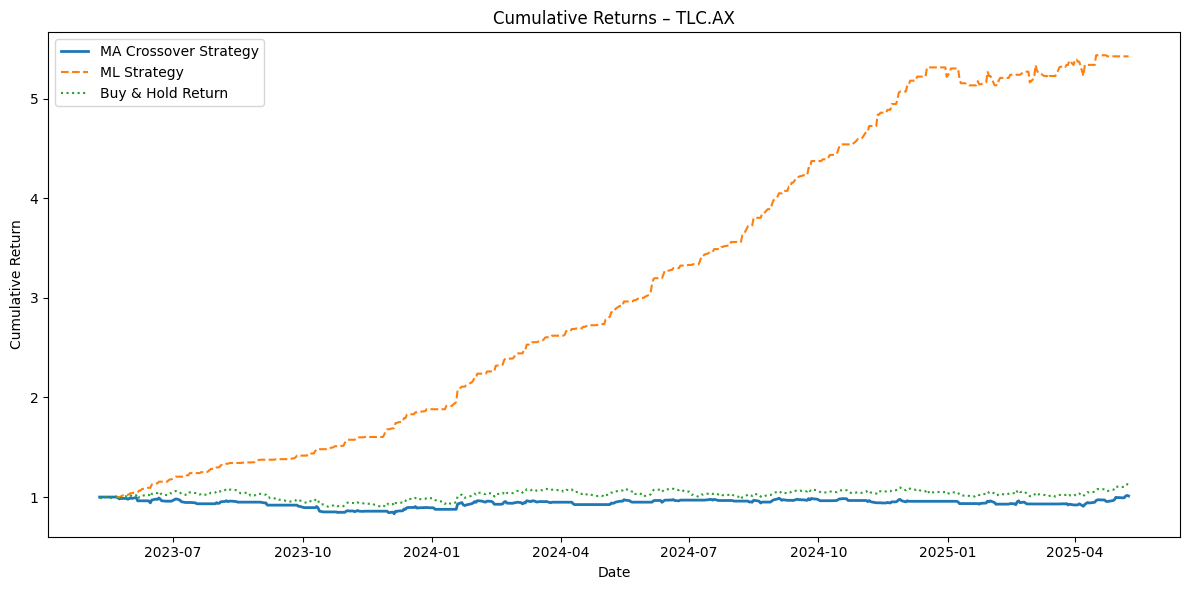

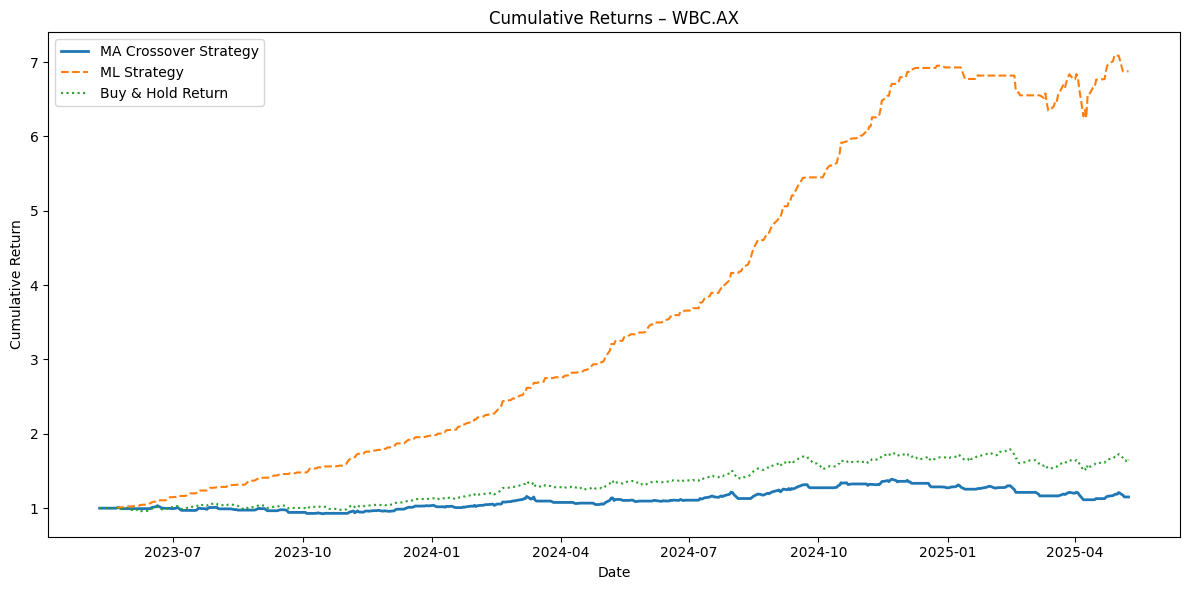

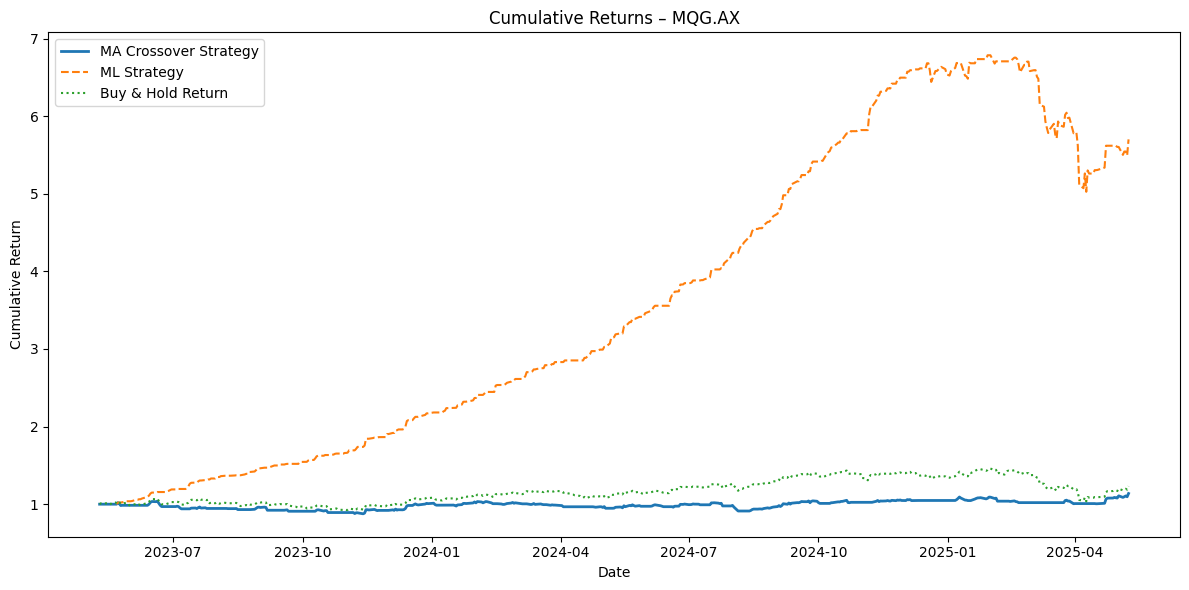

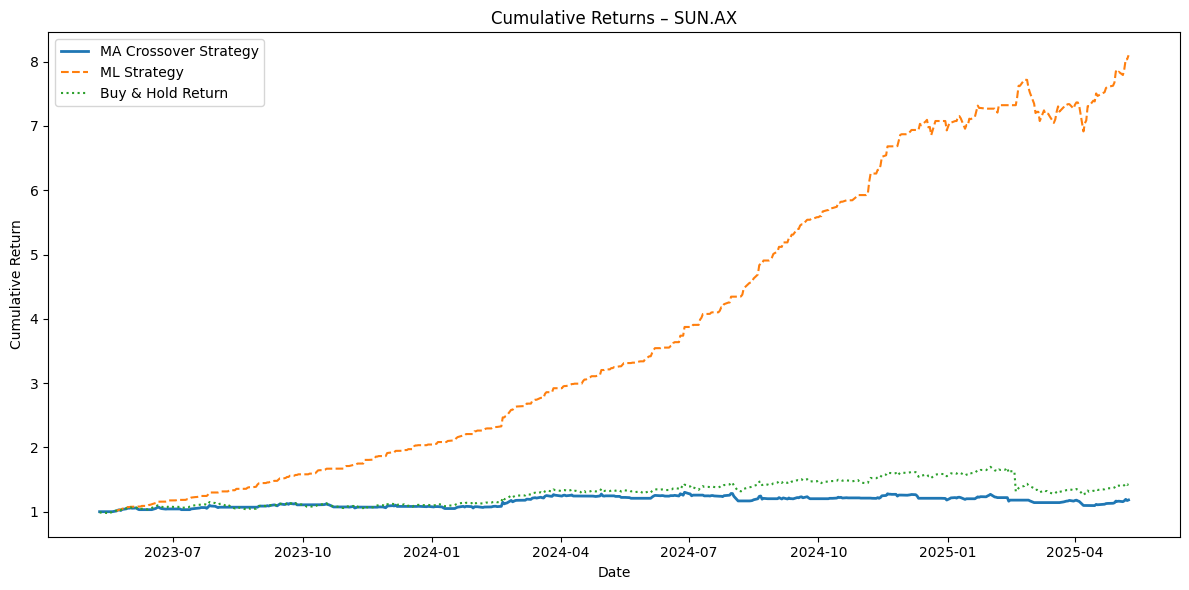

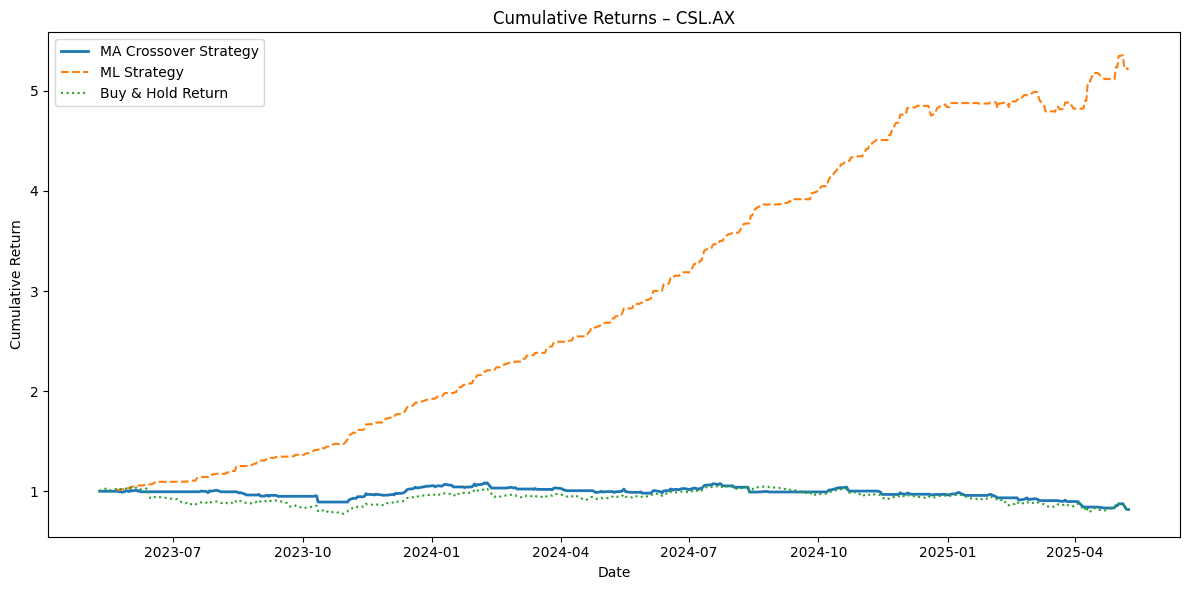

In [10]:
for ticker_symbol, stock_prices in stock_data.items():
    # Create DataFrame from closing prices
    data = pd.DataFrame(stock_prices)
    data['Close'] = data['Close'].astype(float)

    # Calculate moving averages
    data['Short_MA'] = data['Close'].rolling(window=3).mean()
    data['Long_MA'] = data['Close'].rolling(window=9).mean()

    # Feature Engineering
    data['Return'] = data['Close'].pct_change()
    data['Momentum'] = data['Close'].diff()
    data['Volatility'] = data['Return'].rolling(window=5).std()

    # Define Target
    data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)

    # Generate MA crossover signals
    data['Signal'] = np.where(data['Short_MA'] > data['Long_MA'], 1, 0)
    data['Position'] = data['Signal'].shift()

    # Backtesting MA strategy
    data['daily_return'] = data['Close'].pct_change()
    data['strategy_return'] = data['Position'] * data['daily_return']
    data['cumulative_strategy_return'] = (1 + data['strategy_return']).cumprod()
    data['cumulative_buy_hold_return'] = (1 + data['daily_return']).cumprod()

    # ML Strategy - Prepare data
    ml_data = data[['Short_MA', 'Long_MA', 'Momentum', 'Volatility', 'Target']].dropna()
    X = ml_data[['Short_MA', 'Long_MA', 'Momentum', 'Volatility']]
    y = ml_data['Target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Train ML model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    ml_data['Prediction'] = model.predict(X)

    # ML-based signal & return
    data.loc[ml_data.index, 'ML_Signal'] = ml_data['Prediction']
    data['ML_Strategy_Return'] = data['ML_Signal'].shift() * data['daily_return']
    data['Cumulative_ML_Strategy'] = (1 + data['ML_Strategy_Return']).cumprod()

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(data['cumulative_strategy_return'], label='MA Crossover Strategy', linewidth=2)
    plt.plot(data['Cumulative_ML_Strategy'], label='ML Strategy', linestyle='--')
    plt.plot(data['cumulative_buy_hold_return'], label='Buy & Hold Return', linestyle=':')
    plt.title(f'Cumulative Returns – {ticker_symbol}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [11]:
# Print the results for the stock's moving average crossover strategy
print(f"\nMoving Average Crossover for {ticker_symbol}:")
print(data)



Moving Average Crossover for CSL.AX:
                 Close    Short_MA     Long_MA    Return  Momentum  \
Date                                                                 
2023-05-09  293.361542         NaN         NaN       NaN       NaN   
2023-05-10  296.668732         NaN         NaN  0.011273  3.307190   
2023-05-11  295.494598  295.174957         NaN -0.003958 -1.174133   
2023-05-12  299.760620  297.307983         NaN  0.014437  4.266022   
2023-05-15  301.179413  298.811544         NaN  0.004733  1.418793   
...                ...         ...         ...       ...       ...   
2025-05-05  256.809998  254.779999  247.044442  0.001560  0.399994   
2025-05-06  250.470001  254.563334  248.589998 -0.024687 -6.339996   
2025-05-07  242.979996  250.086665  248.947776 -0.029904 -7.490005   
2025-05-08  239.919998  244.456665  248.728887 -0.012594 -3.059998   
2025-05-09  239.309998  240.736664  248.175554 -0.002543 -0.610001   

            Volatility  Target  Signal  Position  d

## Backtest Performance Metrics

### Sharpe Ratio Evaluation

The Sharpe Ratio is a widely used metric to evaluate the risk-adjusted return of investment strategies. It measures how much excess return a strategy generates for each unit of risk (volatility). A higher Sharpe Ratio indicates a more favorable risk-return trade-off.

We calculated the Sharpe Ratio for three strategies:
- **MA Crossover Strategy**
- **ML-based Strategy**
- **Buy & Hold Benchmark**

This comparison helps assess whether the added complexity of a machine learning model improves performance after adjusting for volatility.


In [13]:
# Sharpe Ratio Calculation
# Assumes daily returns, so we annualize by multiplying mean/std by sqrt(252)

sharpe_ma = (data['strategy_return'].mean() / data['strategy_return'].std()) * np.sqrt(252)
sharpe_ml = (data['ML_Strategy_Return'].mean() / data['ML_Strategy_Return'].std()) * np.sqrt(252)
sharpe_bh = (data['daily_return'].mean() / data['daily_return'].std()) * np.sqrt(252)

print(f"Sharpe Ratio - MA Crossover Strategy: {sharpe_ma:.2f}")
print(f"Sharpe Ratio - ML Strategy: {sharpe_ml:.2f}")
print(f"Sharpe Ratio - Buy & Hold: {sharpe_bh:.2f}")

Sharpe Ratio - MA Crossover Strategy: -0.71
Sharpe Ratio - ML Strategy: 8.31
Sharpe Ratio - Buy & Hold: -0.44


## Real-World Relevance

Algorithmic trading strategies like the **Moving Average Crossover** are foundational in real-world quantitative finance, especially among hedge funds and proprietary trading firms. These strategies are used to:

- Automate trading decisions
- Capture market trends
- Reduce emotional bias in decision-making

Furthermore, the integration of **machine learning models** such as **Random Forests** enables traders to:

- Leverage historical price patterns
- Incorporate technical indicators (e.g., momentum, volatility)
- Enhance prediction accuracy

In professional environments, financial institutions often **combine rule-based strategies with predictive models** to build robust, adaptive systems that operate in **high-frequency and low-latency trading environments**. This hybrid approach reflects the growing role of data-driven intelligence in modern finance.


## Conclusion

This notebook implemented and evaluated two algorithmic trading strategies:

1. **Moving Average Crossover Strategy** — a simple, rule-based approach that signals trades based on short- and long-term moving averages.
2. **Machine Learning Strategy** — a data-driven model using a Random Forest Classifier trained on technical indicators such as momentum, volatility, and moving averages.

Both strategies were backtested using historical stock data, and their performance was compared against a traditional **Buy & Hold** benchmark. Evaluation metrics like the **Sharpe Ratio** revealed the relative risk-adjusted returns of each approach.

Overall, while the Moving Average Crossover offers a reliable and interpretable baseline, the Machine Learning model demonstrated potential for improved returns and adaptability to market conditions. This comparison highlights the growing value of integrating machine learning into quantitative trading workflows for more dynamic and informed decision-making.
